In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

Preprocessing Data

In [3]:
df = pd.read_csv(r'E:/LightCurve/combined_light_curve_data.csv')

In [4]:
df.head()

,label,mjd,flux,flux_error
0,Classical_Cepheids,"[5265.81251, 5266.79609, 5267.78687, 5268.8263...","[17.417, 17.628, 17.246, 17.521, 17.335, 17.36...","[0.011, 0.014, 0.01, 0.012, 0.011, 0.011, 0.01..."
1,Classical_Cepheids,"[5265.83399, 5272.77925, 5275.89946, 5279.7655...","[15.773, 16.047, 15.755, 15.658, 16.02, 15.615...","[0.007, 0.008, 0.007, 0.007, 0.008, 0.007, 0.0..."
2,Classical_Cepheids,"[5265.84446, 5268.8799, 5272.78972, 5275.90995...","[16.463, 16.356, 16.474, 16.412, 16.371, 16.43...","[0.008, 0.007, 0.008, 0.007, 0.008, 0.008, 0.0..."
3,Classical_Cepheids,"[5264.841, 5268.77925, 5271.77332, 5273.7826, ...","[16.142, 16.173, 16.194, 16.123, 16.19, 16.227...","[0.007, 0.008, 0.007, 0.006, 0.007, 0.007, 0.0..."
4,Classical_Cepheids,"[5265.85454, 5270.78161, 5272.90171, 5276.8403...","[16.597, 16.629, 16.327, 16.635, 16.462, 16.43...","[0.008, 0.008, 0.007, 0.008, 0.007, 0.008, 0.0..."


In [5]:
print("Reduced Data Shape:", df.shape)
print(df['label'].value_counts())

Reduced Data Shape: (55057, 4)
label
Sigma_SCT             11680
Classical_Cepheids    11622
RR_Lyrae              10898
Eclipsing             10551
Miras                 10306
Name: count, dtype: int64


In [6]:
def reduce_dataset_size(df, label_column, target_size=7500):
    reduced_dfs = []
    
    for label, group in df.groupby(label_column):
        if len(group) > target_size:
            reduced_group = group.sample(n=target_size, random_state=42)
        else:
            reduced_group = group
        reduced_dfs.append(reduced_group)
    
    reduced_df = pd.concat(reduced_dfs).reset_index(drop=True)
    return reduced_df


# Reducing the dataset size because it was exceeding 32GB RAM Limit
df = reduce_dataset_size(df, label_column='label', target_size=7500)

print("Reduced Data Shape:", df.shape)
print(df['label'].value_counts())

Reduced Data Shape: (37500, 4)
label
Classical_Cepheids    7500
Eclipsing             7500
Miras                 7500
RR_Lyrae              7500
Sigma_SCT             7500
Name: count, dtype: int64


In [22]:
# The data had all the values stored in string format. So we convert it to floats
import numpy as np
def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = df[col].apply(convert_to_float_array)
    return df

def convert_to_float_array(string_array):
    string_array = string_array.strip('[]')  # Remove the outer brackets
    if not string_array:  # Check if the array is empty
        return np.array([])
    float_array = [float(val.strip().replace(',', '')) for val in string_array.split(',')]
    return np.array(float_array, dtype=float)


columns_to_convert = ['mjd', 'flux', 'flux_error']
df = convert_to_numeric(df, columns_to_convert)

# Function to truncate or pad arrays to a fixed size with median values
def truncate_and_pad(arr, target_size):
    arr_length = len(arr)
    if arr_length > target_size:
        return arr[:target_size]
    else:
        median_val = np.median(arr)
        padding = [median_val] * (target_size - arr_length)
        return np.concatenate((arr, padding))

# Function to normalize the values of array
def normalize(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    return (arr - arr_min) / (arr_max - arr_min)

# Truncate or pad arrays to size 350
target_size = 350

for col in columns_to_convert:
    df[col] = df[col].apply(lambda x: truncate_and_pad(x, target_size))

#Normalize the arrays
for col in columns_to_convert:
    df[col] = df[col].apply(lambda x: normalize(x))

print(df.head())


C:\Users\omcch\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\omcch\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\omcch\AppData\Local\Temp\ipykernel_9096\2929671077.py:33: RuntimeWarning: invalid value encountered in divide
  return (arr - arr_min) / (arr_max - arr_min)


                label                                                mjd  \
0  Classical_Cepheids  [0.0, 0.0010629882971039993, 0.007484489474838...   
1  Classical_Cepheids  [0.0, 0.007460637956382153, 0.0170477737740279...   
2  Classical_Cepheids  [0.0, 0.0006646703753508668, 0.007145225750104...   
3  Classical_Cepheids  [0.0, 0.0015970644501540614, 0.016720759467352...   
4  Classical_Cepheids  [0.0, 0.0007713110984454822, 0.004008365027323...   

                                                flux  \
0  [0.5344202898550744, 0.8478260869565251, 0.751...   
1  [0.687500000000005, 0.38636363636364, 0.062499...   
2  [0.7771929824561393, 0.6719298245614016, 0.935...   
3  [0.39969834087481215, 0.9577677224736014, 0.62...   
4  [0.31365313653136756, 0.9077490774907738, 0.75...   

                                          flux_error  
0  [0.3333333333333333, 0.3333333333333333, 0.333...  
1  [0.7500000000000001, 0.5000000000000001, 0.750...  
2  [nan, nan, nan, nan, nan, nan, nan, na

In [24]:
df.head()

,label,mjd,flux,flux_error
0,Classical_Cepheids,"[0.0, 0.0010629882971039993, 0.007484489474838...","[0.5344202898550744, 0.8478260869565251, 0.751...","[0.3333333333333333, 0.3333333333333333, 0.333..."
1,Classical_Cepheids,"[0.0, 0.007460637956382153, 0.0170477737740279...","[0.687500000000005, 0.38636363636364, 0.062499...","[0.7500000000000001, 0.5000000000000001, 0.750..."
2,Classical_Cepheids,"[0.0, 0.0006646703753508668, 0.007145225750104...","[0.7771929824561393, 0.6719298245614016, 0.935...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,Classical_Cepheids,"[0.0, 0.0015970644501540614, 0.016720759467352...","[0.39969834087481215, 0.9577677224736014, 0.62...","[0.16666666666666669, 0.5000000000000001, 0.50..."
4,Classical_Cepheids,"[0.0, 0.0007713110984454822, 0.004008365027323...","[0.31365313653136756, 0.9077490774907738, 0.75...","[0.3333333333333334, 0.3333333333333334, 0.666..."


In [26]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Integer encoding the target labels
df['label_encoded'] = label_encoder.fit_transform(df['label'])

print(df.head())

                label                                                mjd  \
0  Classical_Cepheids  [0.0, 0.0010629882971039993, 0.007484489474838...   
1  Classical_Cepheids  [0.0, 0.007460637956382153, 0.0170477737740279...   
2  Classical_Cepheids  [0.0, 0.0006646703753508668, 0.007145225750104...   
3  Classical_Cepheids  [0.0, 0.0015970644501540614, 0.016720759467352...   
4  Classical_Cepheids  [0.0, 0.0007713110984454822, 0.004008365027323...   

                                                flux  \
0  [0.5344202898550744, 0.8478260869565251, 0.751...   
1  [0.687500000000005, 0.38636363636364, 0.062499...   
2  [0.7771929824561393, 0.6719298245614016, 0.935...   
3  [0.39969834087481215, 0.9577677224736014, 0.62...   
4  [0.31365313653136756, 0.9077490774907738, 0.75...   

                                          flux_error  label_encoded  
0  [0.3333333333333333, 0.3333333333333333, 0.333...              0  
1  [0.7500000000000001, 0.5000000000000001, 0.750...              

In [28]:
#Printing the label mappings for the integer encoding
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Label Mapping:")
for label, integer in label_mapping.items():
    print(f"{label}: {integer}")


Label Mapping:
Classical_Cepheids: 0
Eclipsing: 1
Miras: 2
RR_Lyrae: 3
Sigma_SCT: 4


In [30]:
# dropping redundant label column
# dropping flux_error column because it wasn't adding distinctive information to the light curve
df = df.drop(columns=['label', 'flux_error'])
print(df.head())

                                                 mjd  \
0  [0.0, 0.0010629882971039993, 0.007484489474838...   
1  [0.0, 0.007460637956382153, 0.0170477737740279...   
2  [0.0, 0.0006646703753508668, 0.007145225750104...   
3  [0.0, 0.0015970644501540614, 0.016720759467352...   
4  [0.0, 0.0007713110984454822, 0.004008365027323...   

                                                flux  label_encoded  
0  [0.5344202898550744, 0.8478260869565251, 0.751...              0  
1  [0.687500000000005, 0.38636363636364, 0.062499...              0  
2  [0.7771929824561393, 0.6719298245614016, 0.935...              0  
3  [0.39969834087481215, 0.9577677224736014, 0.62...              0  
4  [0.31365313653136756, 0.9077490774907738, 0.75...              0  


In [32]:
df.columns

Index(['mjd', 'flux', 'label_encoded'], dtype='object')

In [34]:
df

,mjd,flux,label_encoded
0,"[0.0, 0.0010629882971039993, 0.007484489474838...","[0.5344202898550744, 0.8478260869565251, 0.751...",0
1,"[0.0, 0.007460637956382153, 0.0170477737740279...","[0.687500000000005, 0.38636363636364, 0.062499...",0
2,"[0.0, 0.0006646703753508668, 0.007145225750104...","[0.7771929824561393, 0.6719298245614016, 0.935...",0
3,"[0.0, 0.0015970644501540614, 0.016720759467352...","[0.39969834087481215, 0.9577677224736014, 0.62...",0
4,"[0.0, 0.0007713110984454822, 0.004008365027323...","[0.31365313653136756, 0.9077490774907738, 0.75...",0
...,...,...,...
37495,"[0.0, 0.012289468429177467, 0.0259410153367528...","[1.0, 0.5368421052631559, 0.43157894736842206,...",4
37496,"[0.0, 8.854936471356963e-05, 0.001770855159212...","[0.5857142857142886, 0.7142857142857114, 0.551...",4
37497,"[0.0, 0.0008644824706564989, 0.001728806331993...","[0.7159763313609459, 0.7958579881656775, 0.958...",4
37498,"[0.0, 0.012145886278229665, 0.0256379373963776...","[0.08000000000000379, 0.5200000000000009, 0.38...",4


Making Bi-Directional Histograms

In [37]:
def generate_bi_dimensional_histograms(data, bins_dm, bins_dt):
    histograms = []
    for i in range(len(data)):
        light_curve = data.iloc[i]
        
        # Remove NaN values
        light_curve = light_curve.dropna()
        
        dm = np.diff(light_curve['flux'])
        dt = np.diff(light_curve['mjd'])
        
       
        valid_indices = ~np.isnan(dm) & ~np.isnan(dt)
        dm = dm[valid_indices]
        dt = dt[valid_indices]
        
   
        bins_dm = max(1, bins_dm)
        bins_dt = max(1, bins_dt)
        
        hist, xedges, yedges = np.histogram2d(dm, dt, bins=[bins_dm, bins_dt])
        histograms.append(hist)
    return np.array(histograms)

# For making histograms and putting them in the model we require fix bin size for fix input size
fixed_bins_dm = 50  
fixed_bins_dt = 50

In [39]:
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42)

# Generate histograms for training and testing sets
X_train_hist = generate_bi_dimensional_histograms(train_df, fixed_bins_dm, fixed_bins_dt)
X_test_hist = generate_bi_dimensional_histograms(test_df, fixed_bins_dm, fixed_bins_dt)

# Check the shapes of the generated histograms
print(f'Original X_train_hist shape: {X_train_hist.shape}')
print(f'Original X_test_hist shape: {X_test_hist.shape}')

# Reshape histograms to match the expected input shape for LSTM
# Assuming the histograms are 2D and need to be reshaped to 3D
X_train_hist = X_train_hist.reshape((X_train_hist.shape[0], X_train_hist.shape[1], X_train_hist.shape[2], 1))
X_test_hist = X_test_hist.reshape((X_test_hist.shape[0], X_test_hist.shape[1], X_test_hist.shape[2], 1))

# Check the shapes after reshaping
print(f'Reshaped X_train_hist shape: {X_train_hist.shape}')
print(f'Reshaped X_test_hist shape: {X_test_hist.shape}')

# Extract labels
y_train = train_df['label_encoded'].values
y_test = test_df['label_encoded'].values

# Convert labels to categorical
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f'y_train_cat shape: {y_train_cat.shape}')
print(f'y_test_cat shape: {y_test_cat.shape}')

Original X_train_hist shape: (18750, 50, 50)
Original X_test_hist shape: (18750, 50, 50)
Reshaped X_train_hist shape: (18750, 50, 50, 1)
Reshaped X_test_hist shape: (18750, 50, 50, 1)
y_train_cat shape: (18750, 5)
y_test_cat shape: (18750, 5)


Making the Model

In [52]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_hist.shape[1], X_train_hist.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))  

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

C:\Users\omcch\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 128)             │          91,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,381 (552.27 KB)

 Trainable params: 141,381 (552.27 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Saving the model
model_save_path = './model.h5'  
model.save(model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to ./model.h5


In [62]:
# Implementing the early stopping condition
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train_hist, y_train_cat, epochs=75, batch_size=32, validation_data=(X_test_hist, y_test_cat), callbacks=[early_stopping])

Epoch 1/75
586/586 ━━━━━━━━━━━━━━━━━━━━ 46s 65ms/step - accuracy: 0.6282 - loss: 0.9227 - val_accuracy: 0.8174 - val_loss: 0.4918
Epoch 2/75
586/586 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.8069 - loss: 0.5028 - val_accuracy: 0.8334 - val_loss: 0.4398
Epoch 3/75
586/586 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.8398 - loss: 0.4272 - val_accuracy: 0.8566 - val_loss: 0.3893
Epoch 4/75
586/586 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.8569 - loss: 0.3851 - val_accuracy: 0.8724 - val_loss: 0.3654
Epoch 5/75
586/586 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.8718 - loss: 0.3489 - val_accuracy: 0.8855 - val_loss: 0.3309
Epoch 6/75
586/586 ━━━━━━━━━━━━━━━━━━━━ 38s 64ms/step - accuracy: 0.8893 - loss: 0.3171 - val_accuracy: 0.8881 - val_loss: 0.3206
Epoch 7/75
586/586 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - accuracy: 0.8944 - loss: 0.2999 - val_accuracy: 0.8931 - val_loss: 0.3130
Epoch 8/75
586/586 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - accuracy: 0.9002 - loss: 0.2877 - 

Evaluating the Model

586/586 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9115 - loss: 0.2802
Test Loss: 0.27304166555404663
Test Accuracy: 0.9124266505241394


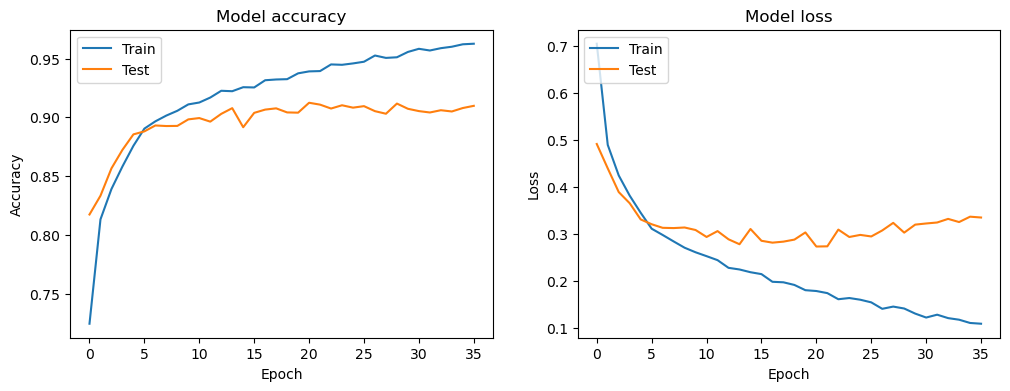

In [64]:

#evaluating model for test finally
loss, accuracy = model.evaluate(X_test_hist, y_test_cat)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

586/586 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.94      0.93      3718
     Class 1       0.98      0.98      0.98      3846
     Class 2       0.92      0.94      0.93      3666
     Class 3       0.88      0.83      0.86      3699
     Class 4       0.85      0.86      0.86      3821

    accuracy                           0.91     18750
   macro avg       0.91      0.91      0.91     18750
weighted avg       0.91      0.91      0.91     18750



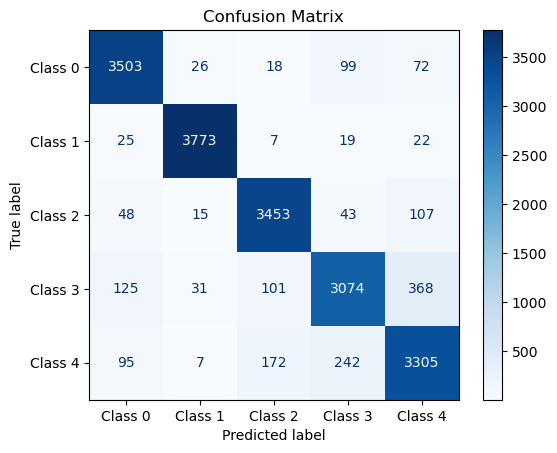

     Class  Precision    Recall  F1 Score  Support
0  Class 0   0.922813  0.942173  0.932393     3718
1  Class 1   0.979491  0.981019  0.980255     3846
2  Class 2   0.920555  0.941899  0.931104     3666
3  Class 3   0.884095  0.831035  0.856745     3699
4  Class 4   0.853123  0.864957  0.858999     3821
Overall Accuracy: 0.9124


In [66]:
# Predict on test data
y_pred_prob = model.predict(X_test_hist)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calculate metrics
report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(num_classes)])
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Class {i}' for i in range(num_classes)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Precision, Recall, F1 Score, and Support
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_scores = 2 * precision * recall / (precision + recall)
support = np.sum(cm, axis=1)

# Display metrics
metrics_df = pd.DataFrame({
    'Class': [f'Class {i}' for i in range(num_classes)],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_scores,
    'Support': support
})
print(metrics_df)

# Overall metrics
overall_accuracy = np.trace(cm) / np.sum(cm)
print(f'Overall Accuracy: {overall_accuracy:.4f}')